In [5]:
import pandas as pd
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
df = pd.read_csv('/Users/daniyalrosli/emotionAI/tweet_emotions.csv')



In [3]:
# data info

df.info()
df.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet_id   40000 non-null  int64 
 1   sentiment  40000 non-null  object
 2   content    40000 non-null  object
dtypes: int64(1), object(2)
memory usage: 937.6+ KB


,tweet_id,sentiment,content
count,4.000000e+04,40000,40000
unique,NaN,13,39827
top,NaN,neutral,I just received a mothers day card from my lov...
freq,NaN,8638,14
mean,1.845184e+09,NaN,NaN
std,1.188579e+08,NaN,NaN
min,1.693956e+09,NaN,NaN
25%,1.751431e+09,NaN,NaN
50%,1.855443e+09,NaN,NaN
75%,1.962781e+09,NaN,NaN


In [4]:
# data cleaning

df.isnull().sum()
df.dropna(inplace=True)
df.isnull().sum()



tweet_id     0
sentiment    0
content      0
dtype: int64

In [13]:
#data preprocessing

def clean_text(text):
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r'\@\w+|\#', '', text)  # Remove mentions and hashtags
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    text = text.lower()  # Convert to lowercase
    return text

In [14]:
# Apply the clean_text function to the 'content' column
df['cleaned_content'] = df['content'].apply(clean_text)

In [19]:
# Step 3: Feature Engineering with TF-IDF
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X = vectorizer.fit_transform(df['cleaned_content'])
y = df['sentiment']

# Step 4: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
# Step 5: Model Training
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train)

# Step 6: Model Evaluation
y_pred = model.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

       anger       0.00      0.00      0.00        19
     boredom       0.00      0.00      0.00        31
       empty       0.00      0.00      0.00       162
  enthusiasm       0.00      0.00      0.00       163
         fun       0.17      0.02      0.04       338
   happiness       0.35      0.38      0.36      1028
        hate       0.51      0.15      0.23       268
        love       0.50      0.37      0.42       762
     neutral       0.34      0.55      0.42      1740
      relief       0.41      0.03      0.05       352
     sadness       0.32      0.24      0.27      1046
    surprise       0.37      0.04      0.08       425
       worry       0.32      0.49      0.39      1666

    accuracy                           0.35      8000
   macro avg       0.25      0.17      0.17      8000
weighted avg       0.34      0.35      0.31      8000



/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


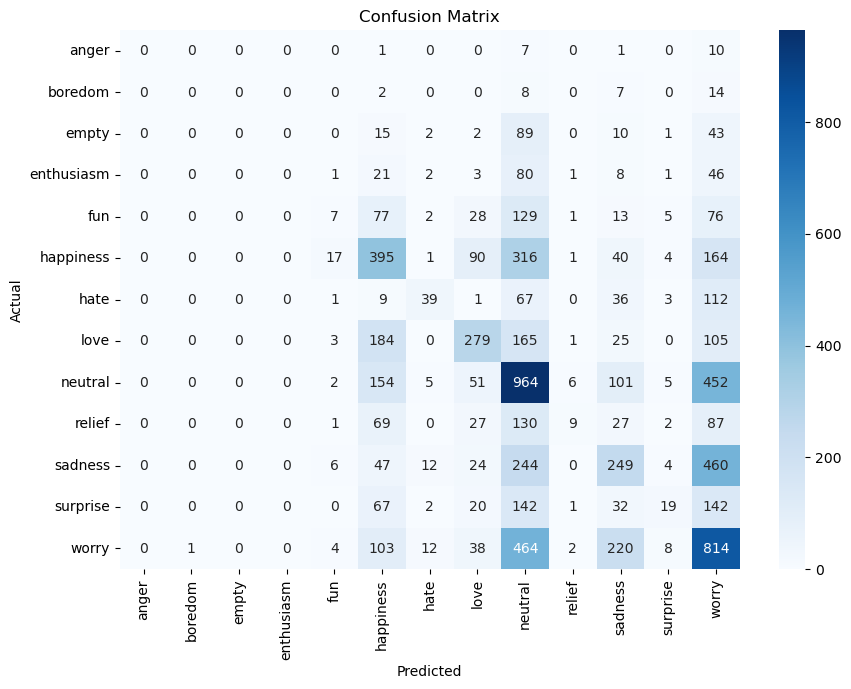

In [10]:
# Confusion Matrix Visualization
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=model.classes_, yticklabels=model.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Accuracy: 0.346875
Precision: 0.33721073404076096
Recall: 0.346875
F1 Score: 0.3113654251353506
ROC AUC Score: 0.686480717704266


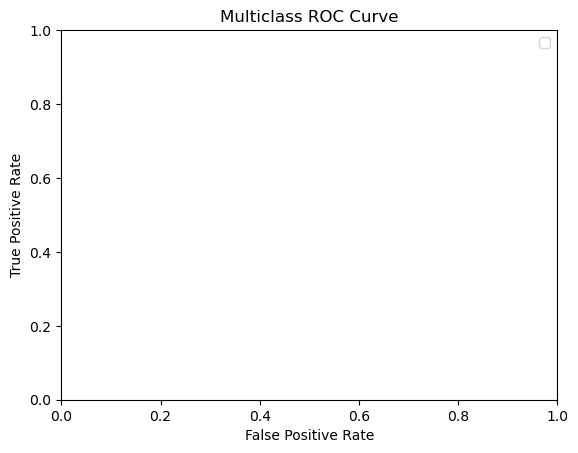

In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from scipy.special import softmax

# Calculate accuracy, precision, recall, and F1-score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Calculate ROC AUC score
y_prob = model.predict_proba(X_test)
y_prob = softmax(y_prob, axis=1)  # Ensure probabilities sum to 1.0
roc_auc = roc_auc_score(y_test, y_prob, multi_class='ovr')

print(f"ROC AUC Score: {roc_auc}")

# Plot ROC curve for each class
fpr = {}
tpr = {}
thresh = {}

for i, label in enumerate(model.classes_):
    fpr[label], tpr[label], thresh[label] = roc_curve(y_test, y_prob[:, i], pos_label=label)



plt.title('Multiclass ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
plt.show()

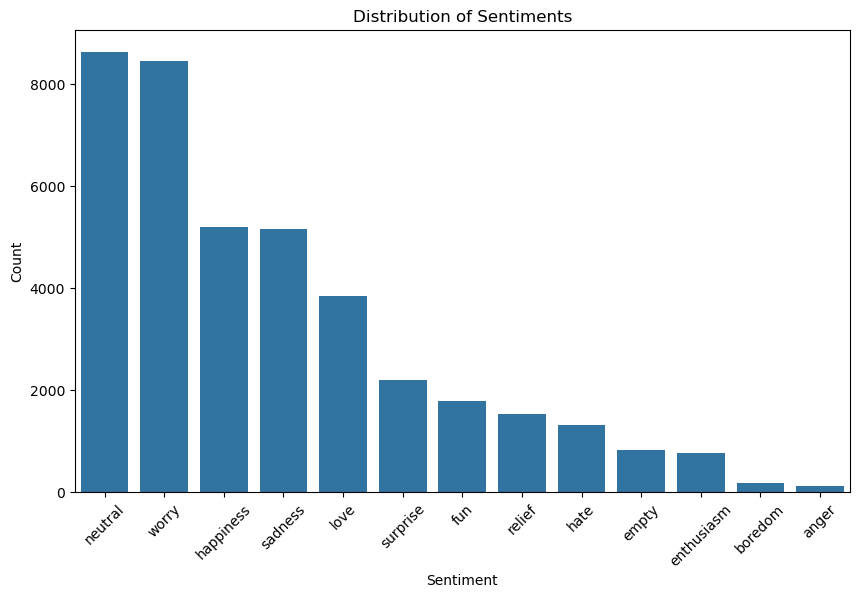

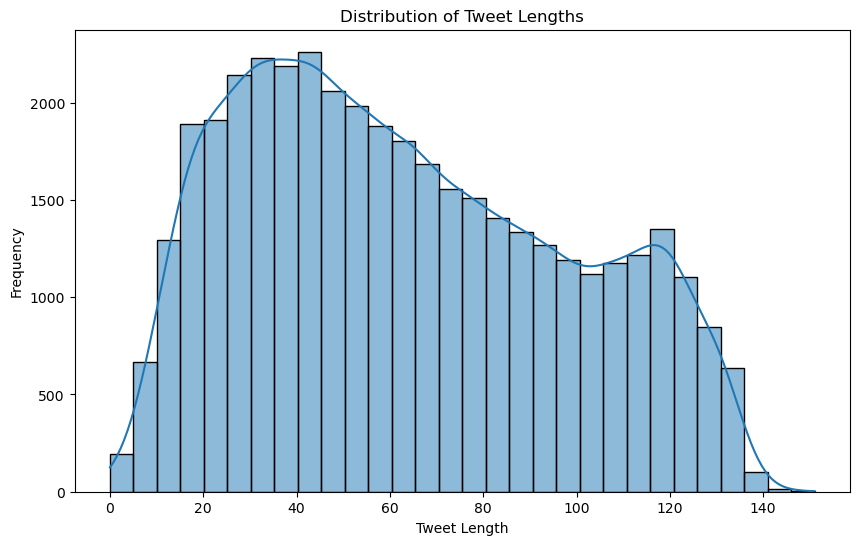

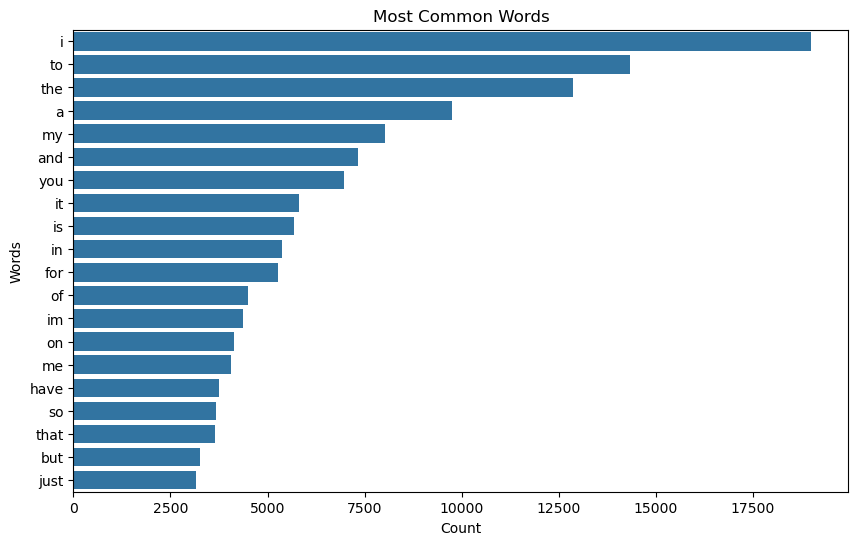

In [14]:
from collections import Counter

# Distribution of sentiments
plt.figure(figsize=(10, 6))
sns.countplot(x='sentiment', data=df, order=df['sentiment'].value_counts().index)
plt.title('Distribution of Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Length of tweets
df['tweet_length'] = df['cleaned_content'].apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(df['tweet_length'], bins=30, kde=True)
plt.title('Distribution of Tweet Lengths')
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')
plt.show()

# Most common words
all_words = ' '.join(df['cleaned_content']).split()
word_freq = Counter(all_words)
common_words = word_freq.most_common(20)

words, counts = zip(*common_words)
plt.figure(figsize=(10, 6))
sns.barplot(x=list(counts), y=list(words))
plt.title('Most Common Words')
plt.xlabel('Count')
plt.ylabel('Words')
plt.show()

In [15]:
# Step 7: Predict on New Data
def predict_emotion(text):
    cleaned_text = clean_text(text)
    transformed_text = vectorizer.transform([cleaned_text])
    prediction = model.predict(transformed_text)[0]
    return prediction

In [16]:
# Example Usage
sample_text = "I'm so happy today! Life is great."
print(f"Predicted Emotion: {predict_emotion(sample_text)}")

Predicted Emotion: happiness


In [17]:
# Example Usage
sample_text = "I hate Mondays. I wish I could stay in bed all day."
print(f"Predicted Emotion: {predict_emotion(sample_text)}")

Predicted Emotion: sadness


In [19]:
# Example Usage
sample_text = "Dont test my patience" 
print(f"Predicted Emotion: {predict_emotion(sample_text)}")

Predicted Emotion: worry


In [20]:
sample_text = "HAHAHAJSJSJJS"
print(f"Predicted Emotion: {predict_emotion(sample_text)}")

Predicted Emotion: neutral


In [21]:
#predict anger 

sample_text = "I am so angry right now"
print(f"Predicted Emotion: {predict_emotion(sample_text)}")

Predicted Emotion: sadness


In [22]:
# Example Usage
sample_text = "This is so funny" 
print(f"Predicted Emotion: {predict_emotion(sample_text)}")

Predicted Emotion: neutral


In [23]:
#example usage

sample_text = "I am so sad right now"
print(f"Predicted Emotion: {predict_emotion(sample_text)}")

# Example Usage

sample_text = "I am so happy right now"
print(f"Predicted Emotion: {predict_emotion(sample_text)}")

# Example Usage
sample_text = "I am so excited right now"
print(f"Predicted Emotion: {predict_emotion(sample_text)}")

# Example Usage
sample_text = "I am so scared right now"

print(f"Predicted Emotion: {predict_emotion(sample_text)}")

# Example Usage

sample_text = "I am so surprised right now"
print(f"Predicted Emotion: {predict_emotion(sample_text)}")

# Example Usage


sample_text = "I am so disgusted right now"
print(f"Predicted Emotion: {predict_emotion(sample_text)}")

Predicted Emotion: sadness
Predicted Emotion: happiness
Predicted Emotion: happiness
Predicted Emotion: worry
Predicted Emotion: neutral
Predicted Emotion: neutral


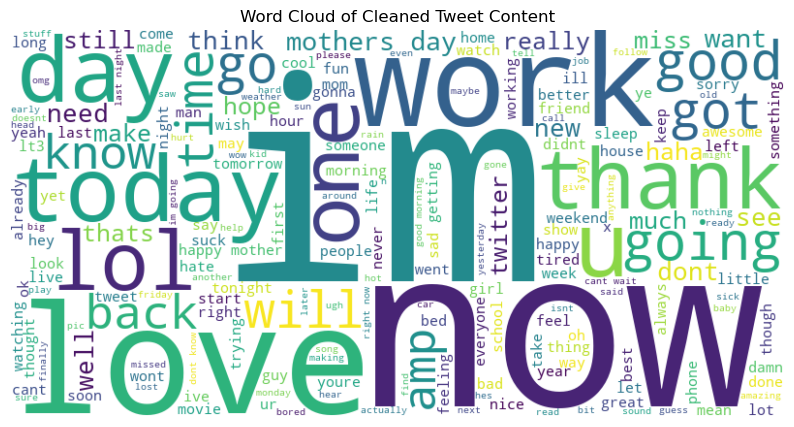

In [15]:
from wordcloud import WordCloud

# Combine all cleaned content into a single string
all_text = ' '.join(df['cleaned_content'])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Cleaned Tweet Content')
plt.show()

In [21]:
import joblib

# Save the trained model to a file
joblib.dump(model, 'emotion_model.pkl')

['emotion_model.pkl']

In [22]:
#vectorizer = joblib.load('tfidf_vectorizer.pkl')

# Save the TF-IDF vectorizer to a file
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')

['tfidf_vectorizer.pkl']